In [130]:
# import libraries
import pandas as pd
import numpy as np
from time import time

import zipfile
import os
from os import path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn import metrics

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [131]:
# download data from kaggle using kaggle API
os.environ.get('KAGGLE_USERNAME')
os.environ.get('KAGGLE_KEY')

!kaggle competitions download -w -q ieee-fraud-detection

zf = zipfile.ZipFile('ieee-fraud-detection.zip')
zf.extractall()

In [132]:
# load the extracted data from local folder
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

In [133]:
# merge data
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

# have same columns names for both test and test dataset
test.columns = test.columns.str.replace('id-', 'id_')

In [134]:
# dimension of the dataset
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [135]:
# view of the data before merge
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# view of the data before merge
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Data Exploration

In [137]:
print(f'There are {train.isnull().any().sum()} colmns in train dataset with missing values.')

There are 414 colmns in train dataset with missing values.


In [138]:
# print all the columns with percentage of missing values and its data types
for i in train.columns:
    print(i, 'missing values present is:', train[i].isnull().sum(), end = ' ')
    print('type is:', train[i].dtypes, end = ' ')
    print(' and % of missing values:', np.round(train[i].isnull().sum()/train.shape[0]*100, 2))

TransactionID missing values present is: 0 type is: int64  and % of missing values: 0.0
isFraud missing values present is: 0 type is: int64  and % of missing values: 0.0
TransactionDT missing values present is: 0 type is: int64  and % of missing values: 0.0
TransactionAmt missing values present is: 0 type is: float64  and % of missing values: 0.0
ProductCD missing values present is: 0 type is: object  and % of missing values: 0.0
card1 missing values present is: 0 type is: int64  and % of missing values: 0.0
card2 missing values present is: 8933 type is: float64  and % of missing values: 1.51
card3 missing values present is: 1565 type is: float64  and % of missing values: 0.27
card4 missing values present is: 1577 type is: object  and % of missing values: 0.27
card5 missing values present is: 4259 type is: float64  and % of missing values: 0.72
card6 missing values present is: 1571 type is: object  and % of missing values: 0.27
addr1 missing values present is: 65706 type is: float64  a

V42 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V43 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V44 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V45 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V46 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V47 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V48 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V49 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V50 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V51 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V52 missing values present is: 168969 type is: float64  and % of missing values: 28.61
V53 missing values present is: 77096 type i

V138 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V139 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V140 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V141 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V142 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V143 missing values present is: 508589 type is: float64  and % of missing values: 86.12
V144 missing values present is: 508589 type is: float64  and % of missing values: 86.12
V145 missing values present is: 508589 type is: float64  and % of missing values: 86.12
V146 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V147 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V148 missing values present is: 508595 type is: float64  and % of missing values: 86.12
V149 missing values present is: 

V231 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V232 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V233 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V234 missing values present is: 449124 type is: float64  and % of missing values: 76.05
V235 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V236 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V237 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V238 missing values present is: 449124 type is: float64  and % of missing values: 76.05
V239 missing values present is: 449124 type is: float64  and % of missing values: 76.05
V240 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V241 missing values present is: 460110 type is: float64  and % of missing values: 77.91
V242 missing values present is: 

V326 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V327 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V328 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V329 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V330 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V331 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V332 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V333 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V334 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V335 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V336 missing values present is: 508189 type is: float64  and % of missing values: 86.05
V337 missing values present is: 

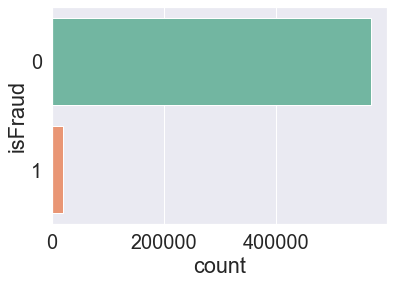

3.5 % of the transactions are fraud.
96.5 % of transactions are fraud.


In [139]:
# visualize the target variable
sns.countplot(y = train['isFraud'], palette = 'Set2')
plt.show()

fraud_trans_per = np.round(train[train['isFraud'] == 1].shape[0]/train.shape[0]*100, 2)

print(f'{fraud_trans_per} % of the transactions are fraud.')
print(f'{100-fraud_trans_per} % of transactions are fraud.')

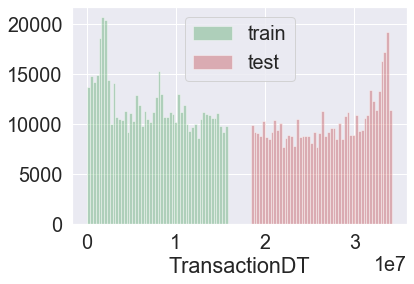

In [140]:
# visualize the time variables for test and train dataset
sns.distplot(train['TransactionDT'], kde = False, color = 'g')
sns.distplot(test['TransactionDT'], kde = False, color = 'r')
plt.legend(['train', 'test'])
plt.show()

In [141]:
# create a new variable of day from the time variable 
train['day'] = (train['TransactionDT']//(3600*24)-1)%7
test['day'] = (train['TransactionDT']//(3600*24)-1)%7

train_day = (train.groupby(['isFraud'])['day']
             .value_counts(normalize = True)
             .rename('Percentage')
             .mul(100)
             .reset_index()
             .sort_values('day'))

sns.barplot(x = 'day', y = 'Percentage', hue = 'isFraud', data = train_day, palette = 'Set2')
plt.show()

In [143]:
# create a new variable of hours from the time variable 
train['hour'] = (train['TransactionDT']//(3600))%24
test['hour'] = (test['TransactionDT']//(3600))%24

train_hour = (train.groupby(['isFraud'])['hour']
             .value_counts(normalize = True)
             .rename('Percentage')
             .mul(100)
             .reset_index()
             .sort_values('hour'))

sns.barplot(x = 'hour', y = 'Percentage', hue = 'isFraud', data = train_hour, palette = 'Set2')
plt.show()

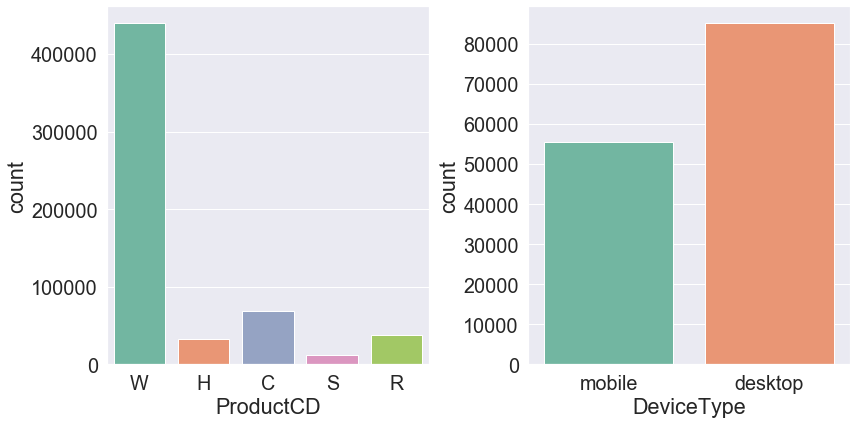

In [145]:
# Visualizing Categorical Variables
f, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(x = 'ProductCD', data = train, ax = axes[0], palette = 'Set2')
sns.countplot(x = 'DeviceType', data = train, ax = axes[1], palette = 'Set2')
plt.tight_layout()

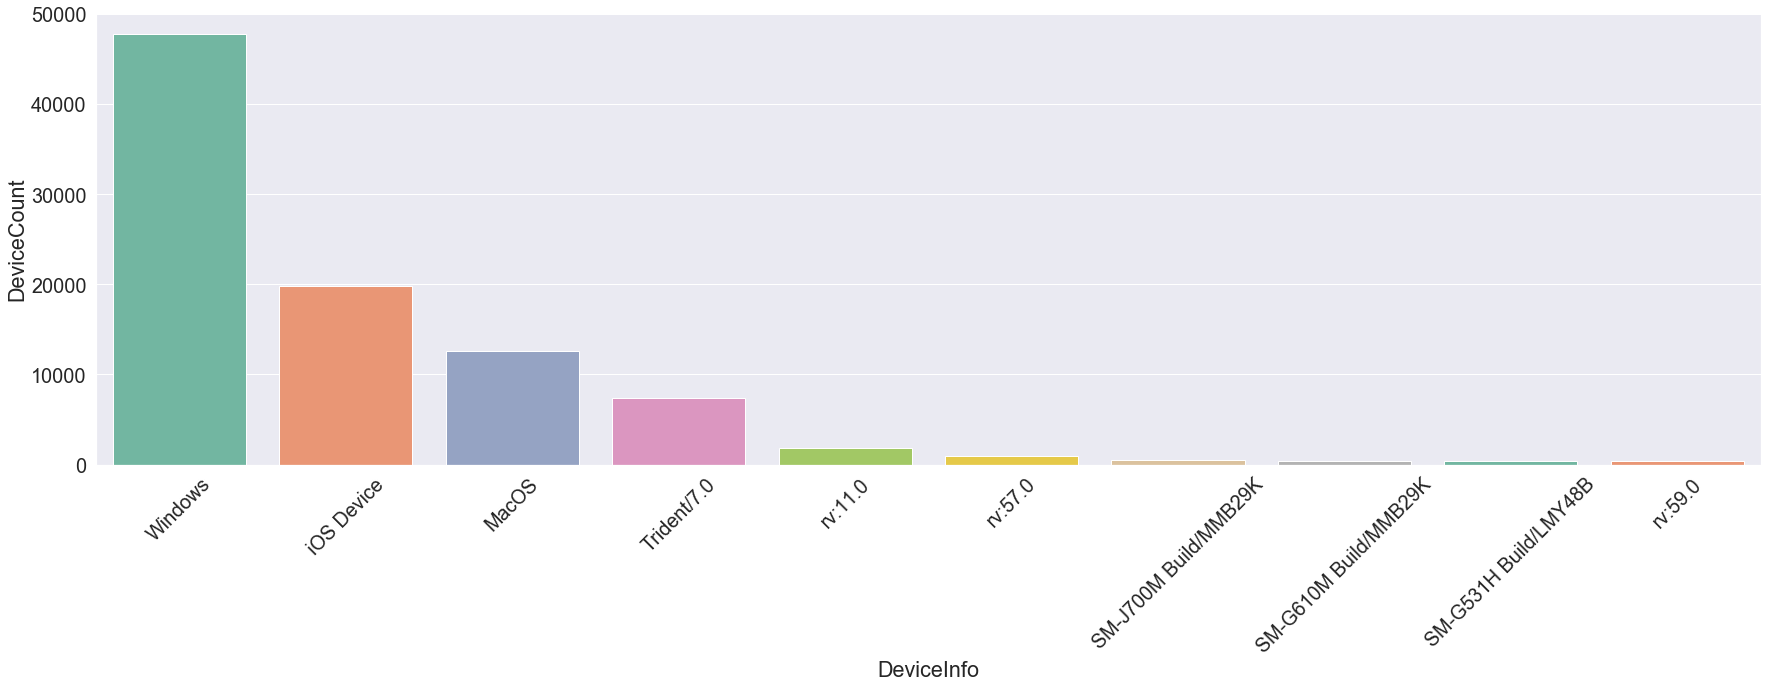

In [146]:
# Visualizing Categorical Variables
group = pd.DataFrame()
group['DeviceCount'] = train.groupby(['DeviceInfo'])['DeviceInfo'].count()
group['DeviceInfo'] = group.index
group_top = group.sort_values(by = 'DeviceCount', ascending = False).head(10)

plt.figure(figsize = (25, 10))
sns.set(font_scale = 1.8)
sns.barplot(x = 'DeviceInfo', y = 'DeviceCount', data = group_top, palette = 'Set2')
plt.xticks(rotation = 45)
plt.tight_layout()

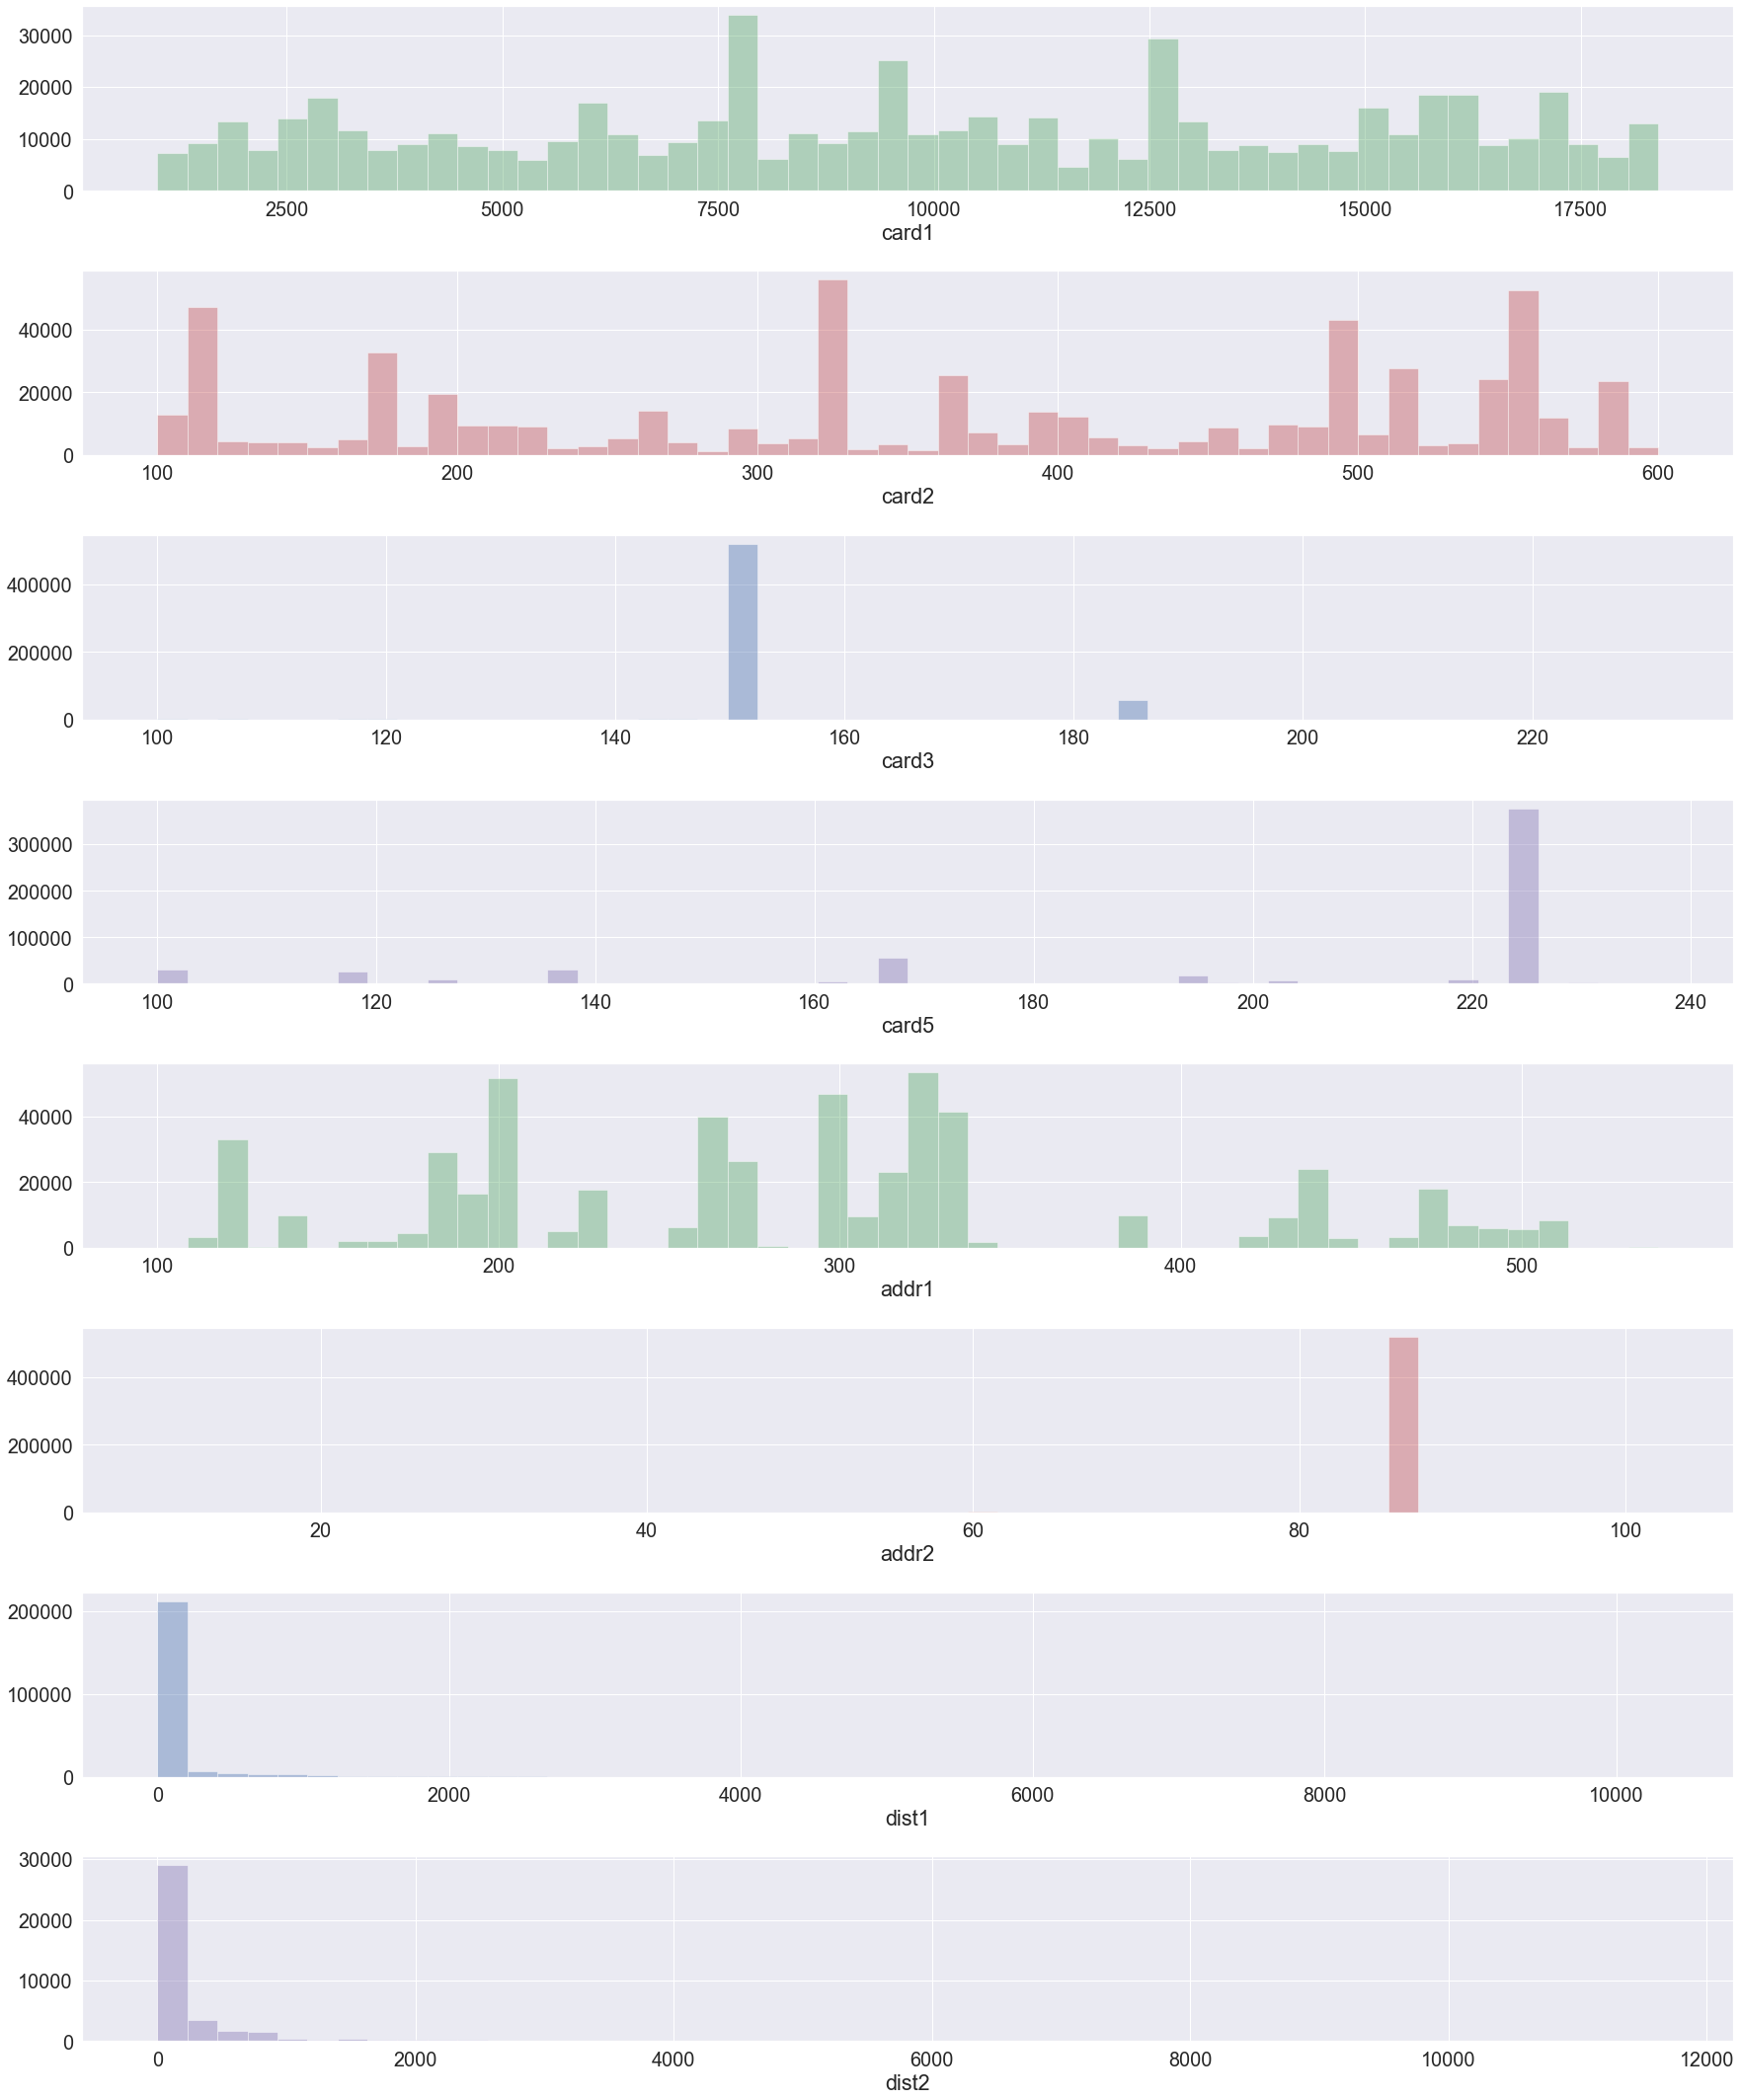

In [147]:
# Visualizing Continous Variables
f, axes = plt.subplots(8, 1, figsize = (25, 30))

sns.distplot(train['card1'], kde = False, ax = axes[0], color = 'g')
sns.distplot(train['card2'].dropna(), kde = False, ax = axes[1], color = 'r')
sns.distplot(train['card3'].dropna(), kde = False, ax = axes[2], color = 'b')
sns.distplot(train['card5'].dropna(), kde = False, ax = axes[3], color = 'm')
sns.distplot(train['addr1'].dropna(), kde = False, ax = axes[4], color = 'g')
sns.distplot(train['addr2'].dropna(), kde = False, ax = axes[5], color = 'r')
sns.distplot(train['dist1'].dropna(), kde = False, ax = axes[6], color = 'b')
sns.distplot(train['dist2'].dropna(), kde = False, ax = axes[7], color = 'm')
plt.tight_layout()

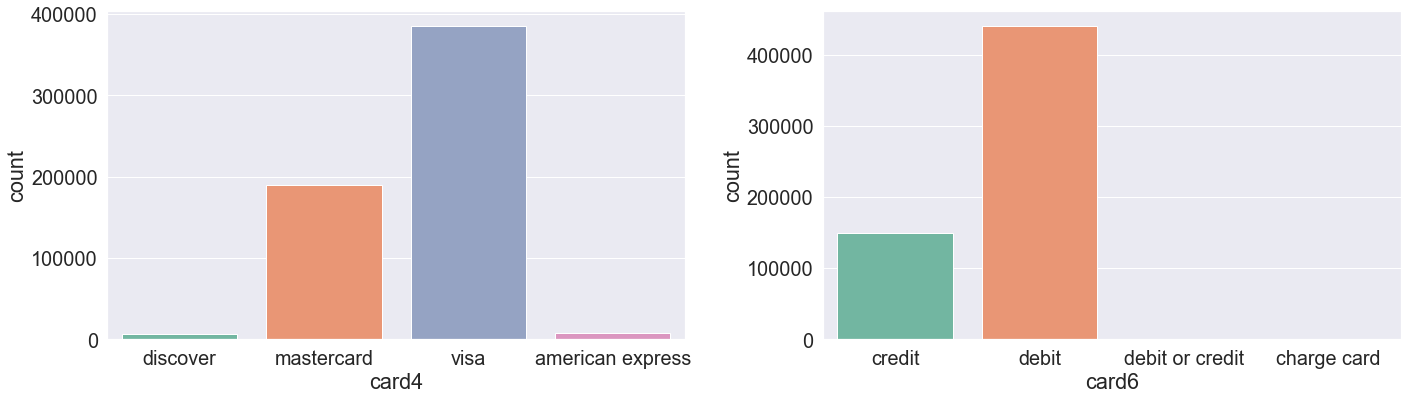

In [148]:
# Visualizing Categorical Variables
f, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.countplot(train['card4'], ax = axes[0], palette = 'Set2')
sns.countplot(train['card6'], ax = axes[1], palette = 'Set2')
plt.tight_layout()

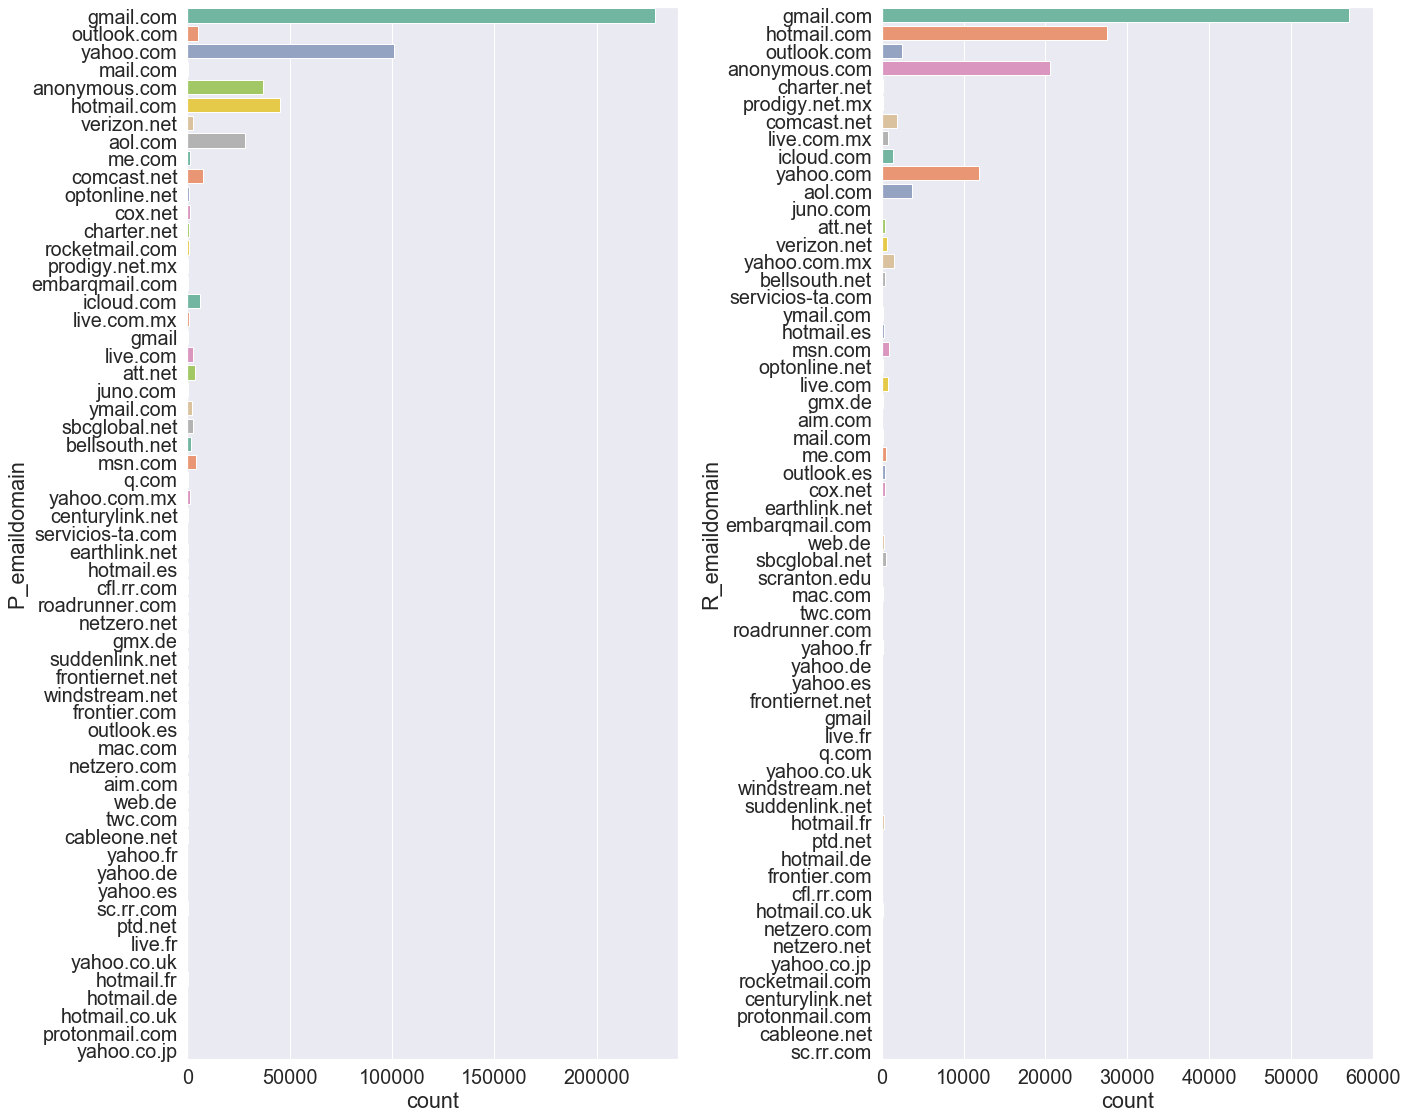

In [149]:
# Visualizing Categorical Variables
f, axes = plt.subplots(1, 2, figsize = (20, 16))

sns.countplot(y = train['P_emaildomain'], ax = axes[0], palette ='Set2')
sns.countplot(y = train['R_emaildomain'], ax = axes[1], palette ='Set2')
plt.tight_layout()

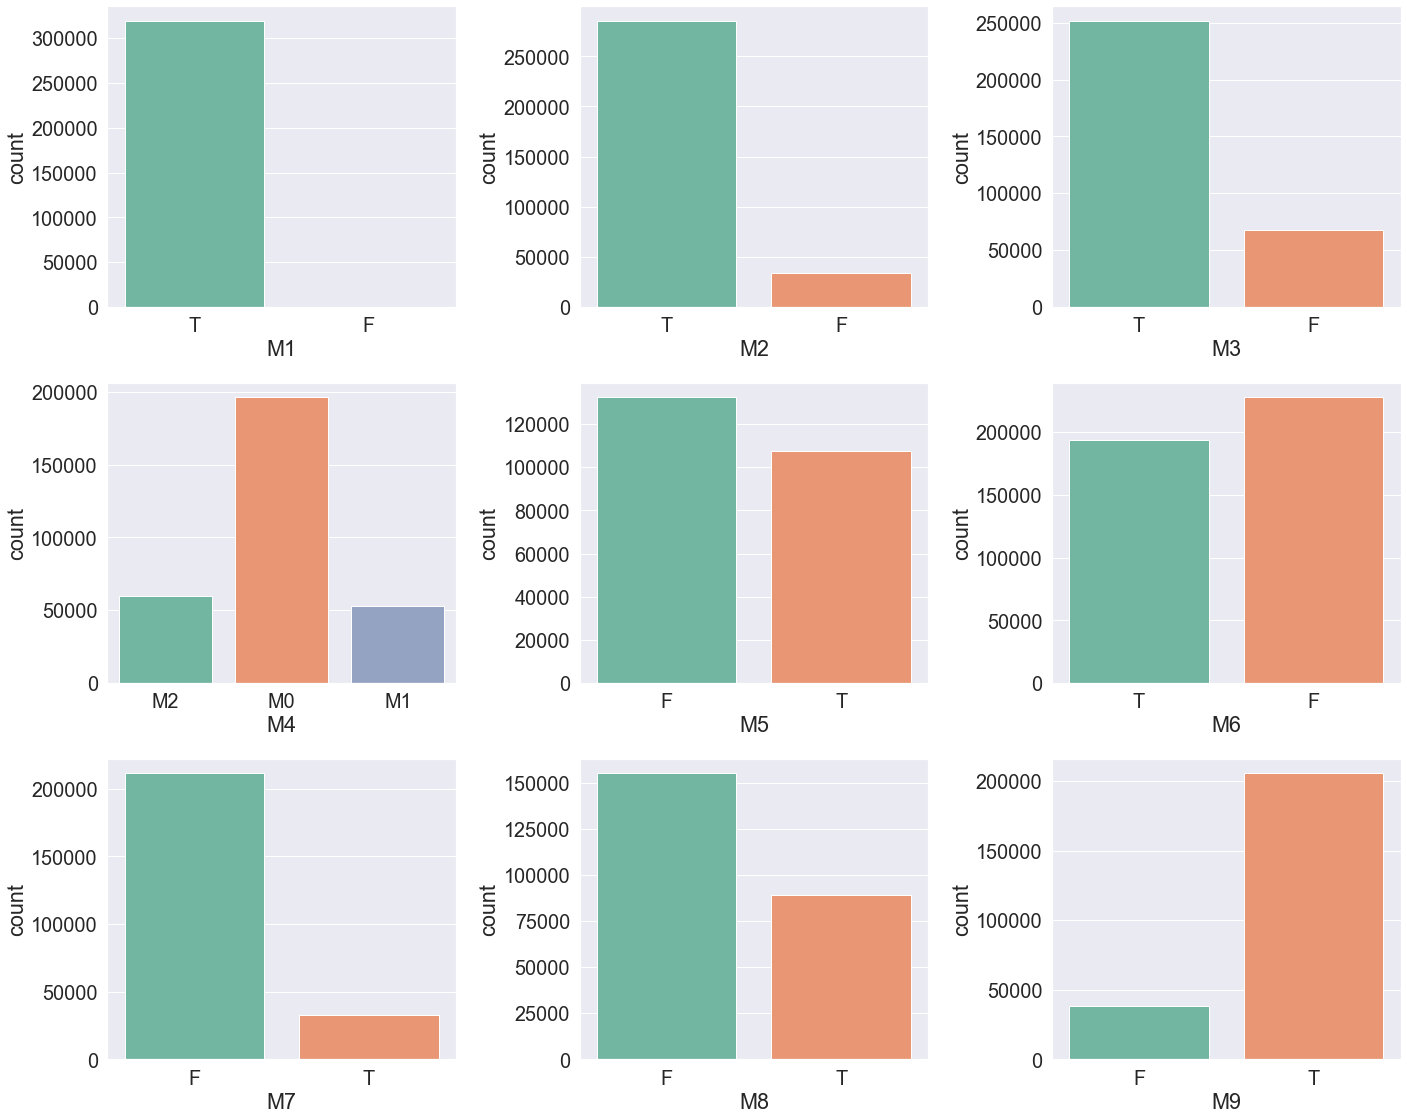

In [150]:
# Visualizing Categorical Variables
M = train.iloc[:,train.columns.get_loc('M1'):train.columns.get_loc('M9')+1]

f, axes = plt.subplots(3, 3, figsize = (20, 16))
count = 0
for i in range(3):
    for j in range(3):
        sns.countplot(M.columns[count], data = M, ax = axes[i, j], palette = 'Set2')
        count += 1
plt.tight_layout()

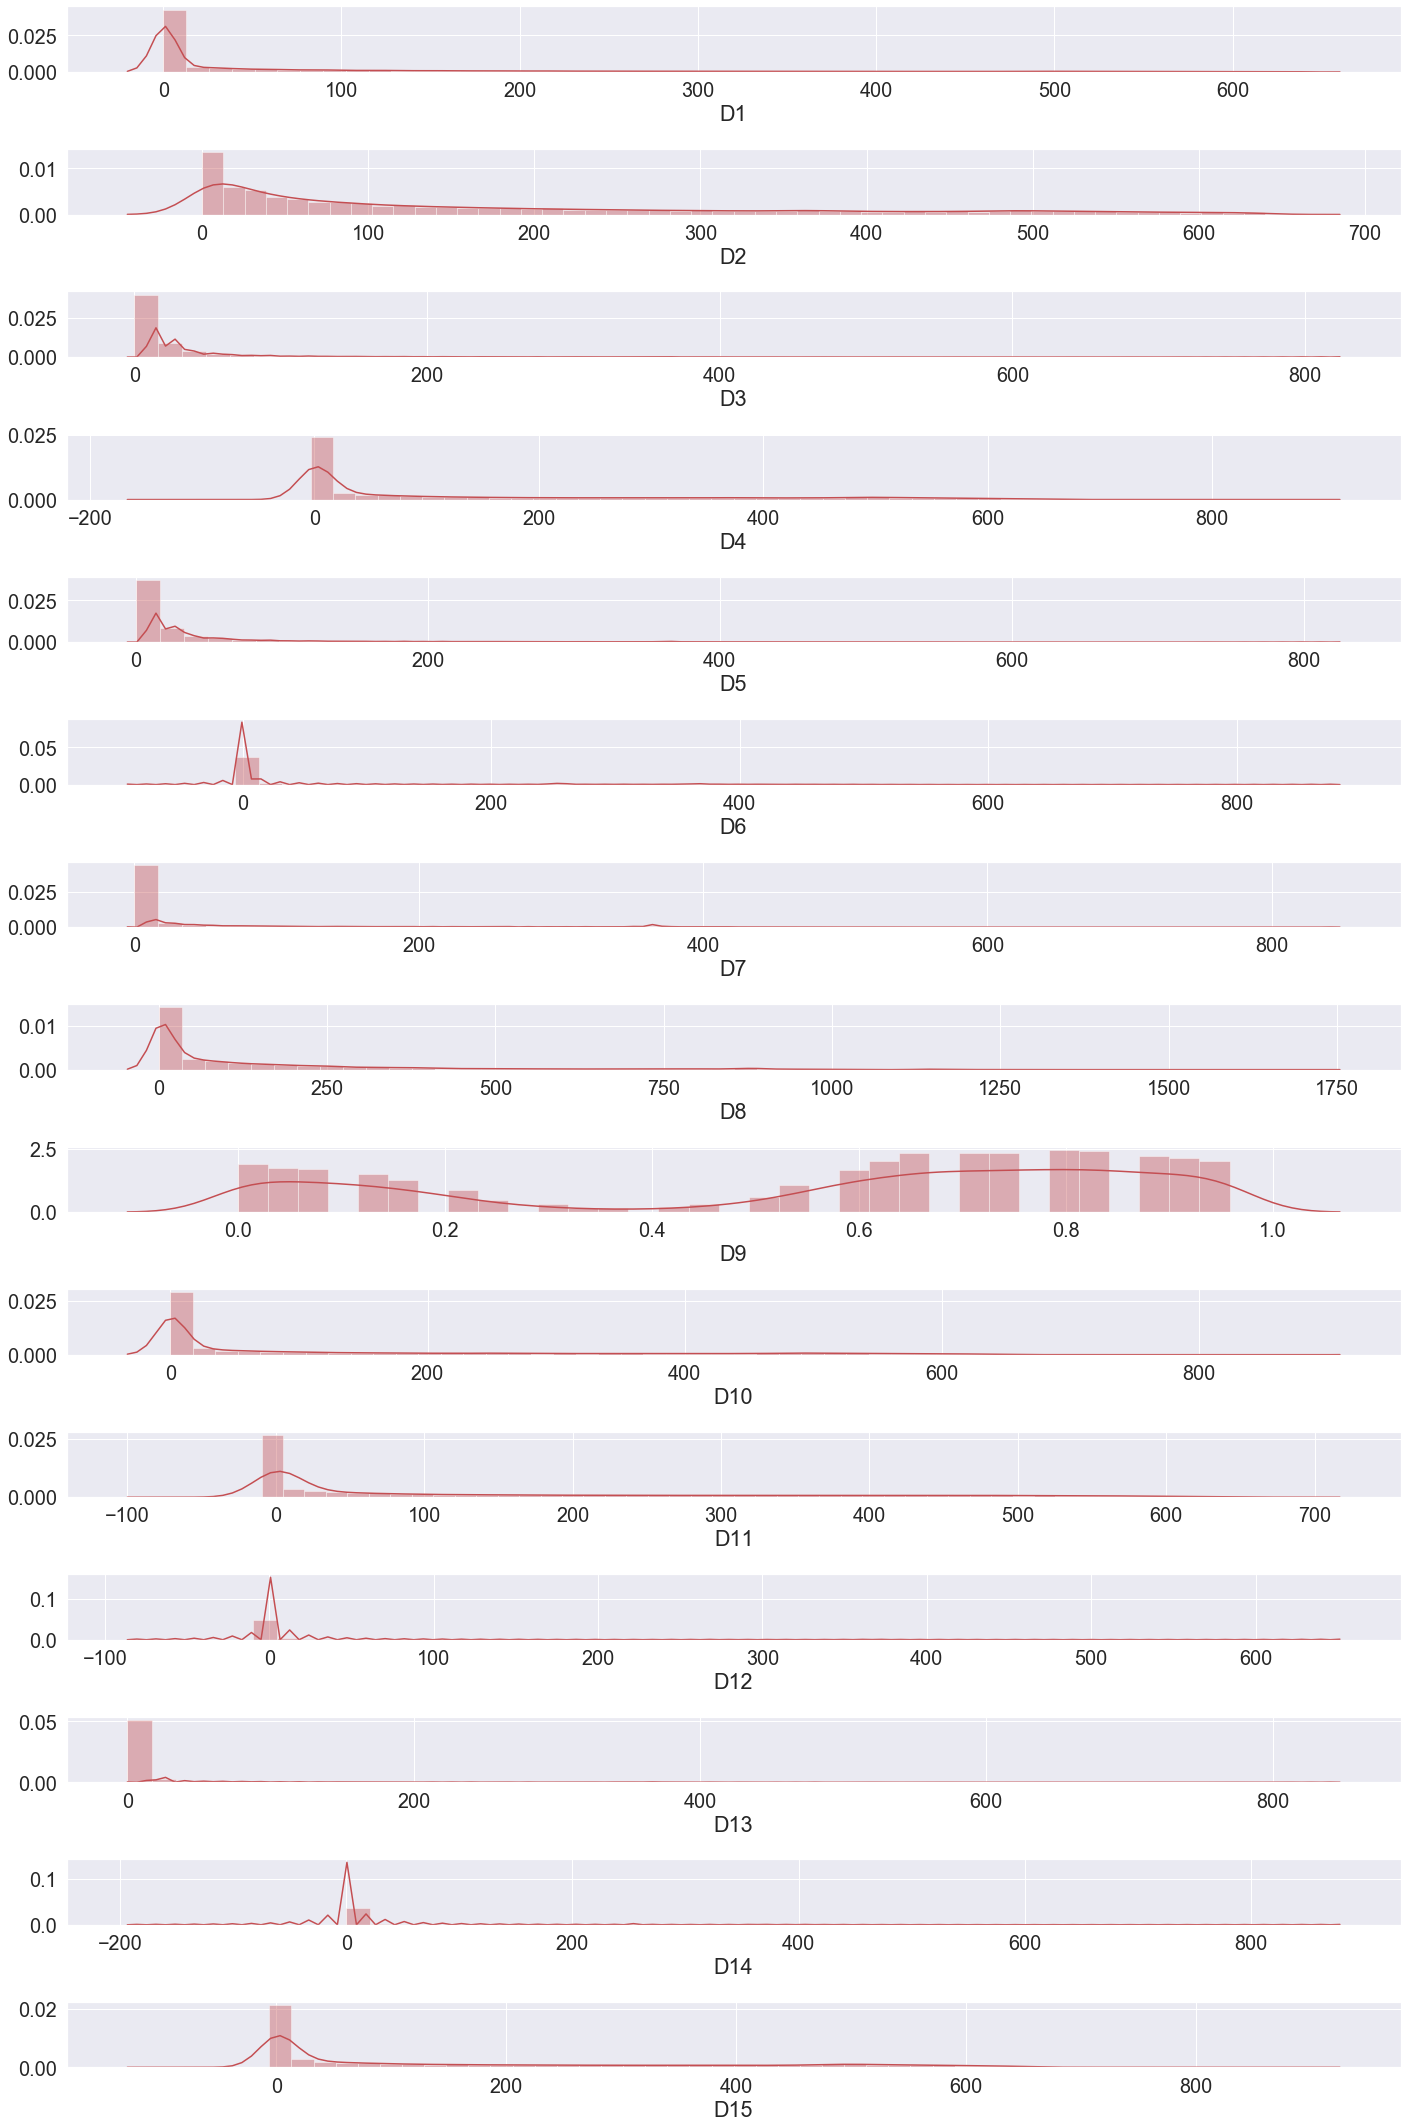

In [151]:
# Visualizing Continous Variables
D = train.iloc[:,train.columns.get_loc('D1'):train.columns.get_loc('D15')+1]

rows = D.shape[1]
f, axes = plt.subplots(rows, 1, figsize = (20, 30))
for i in range(rows):
    sns.distplot(D[D.columns[i]].dropna(), ax = axes[i], color = 'r')
plt.tight_layout()

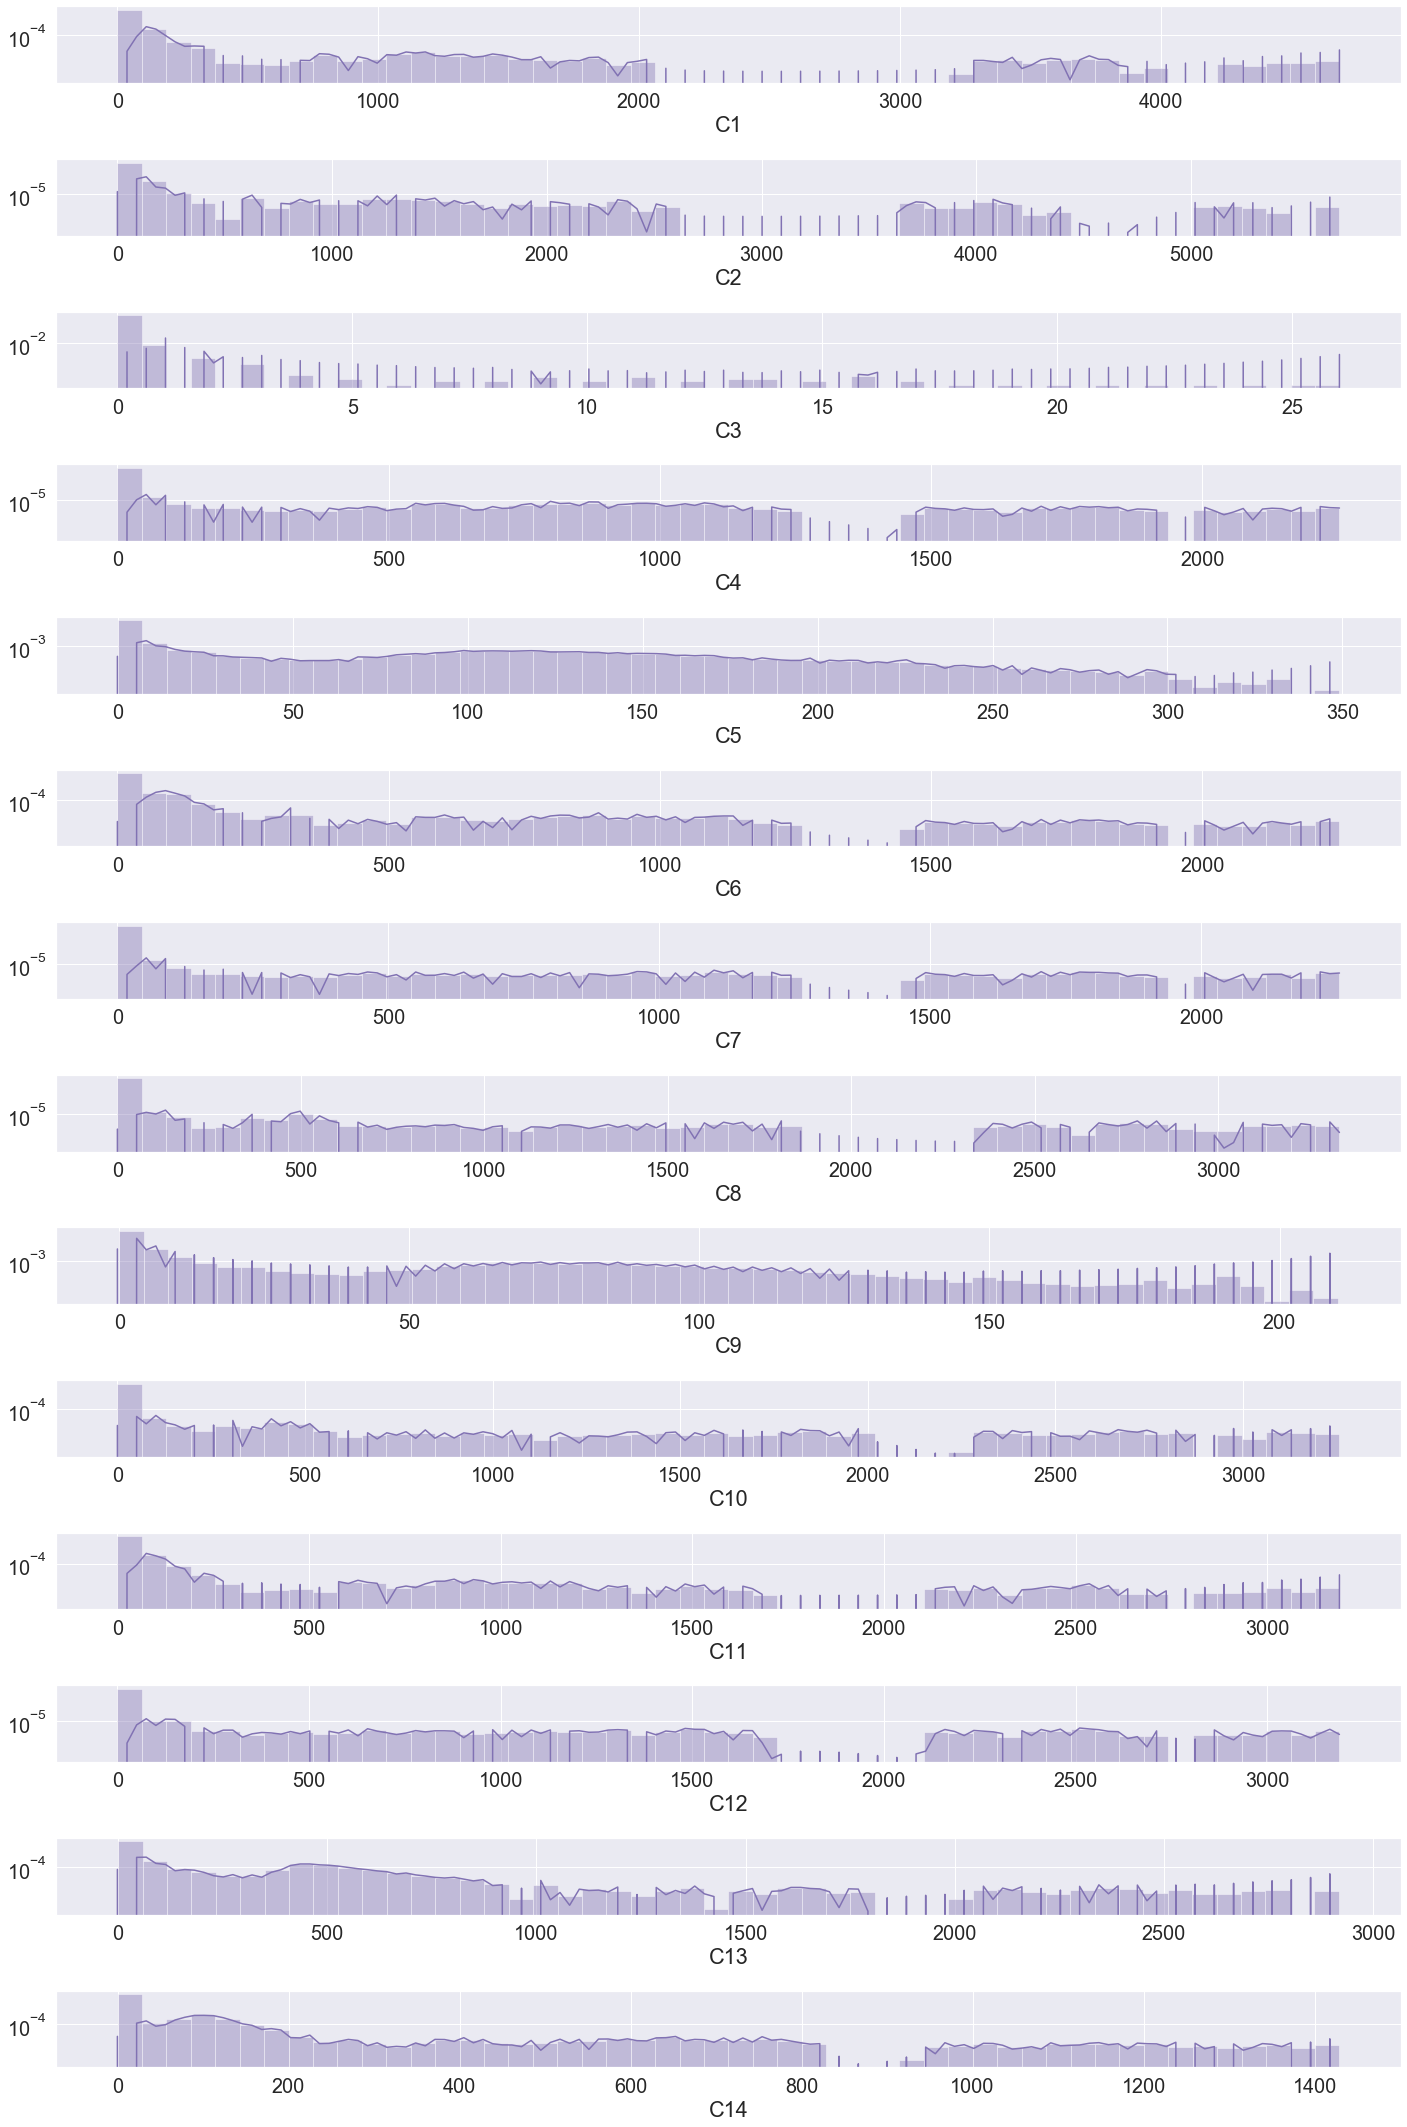

In [152]:
# Visualizing Continous Variables
C = train.iloc[:,train.columns.get_loc('C1'):train.columns.get_loc('C14')+1]

rows = C.shape[1]
f, axes = plt.subplots(rows, 1, figsize = (20, 30))
for i in range(rows):
    sns.distplot(C[C.columns[i]], hist_kws = {'log':True}, ax = axes[i], color = 'm')
plt.tight_layout()

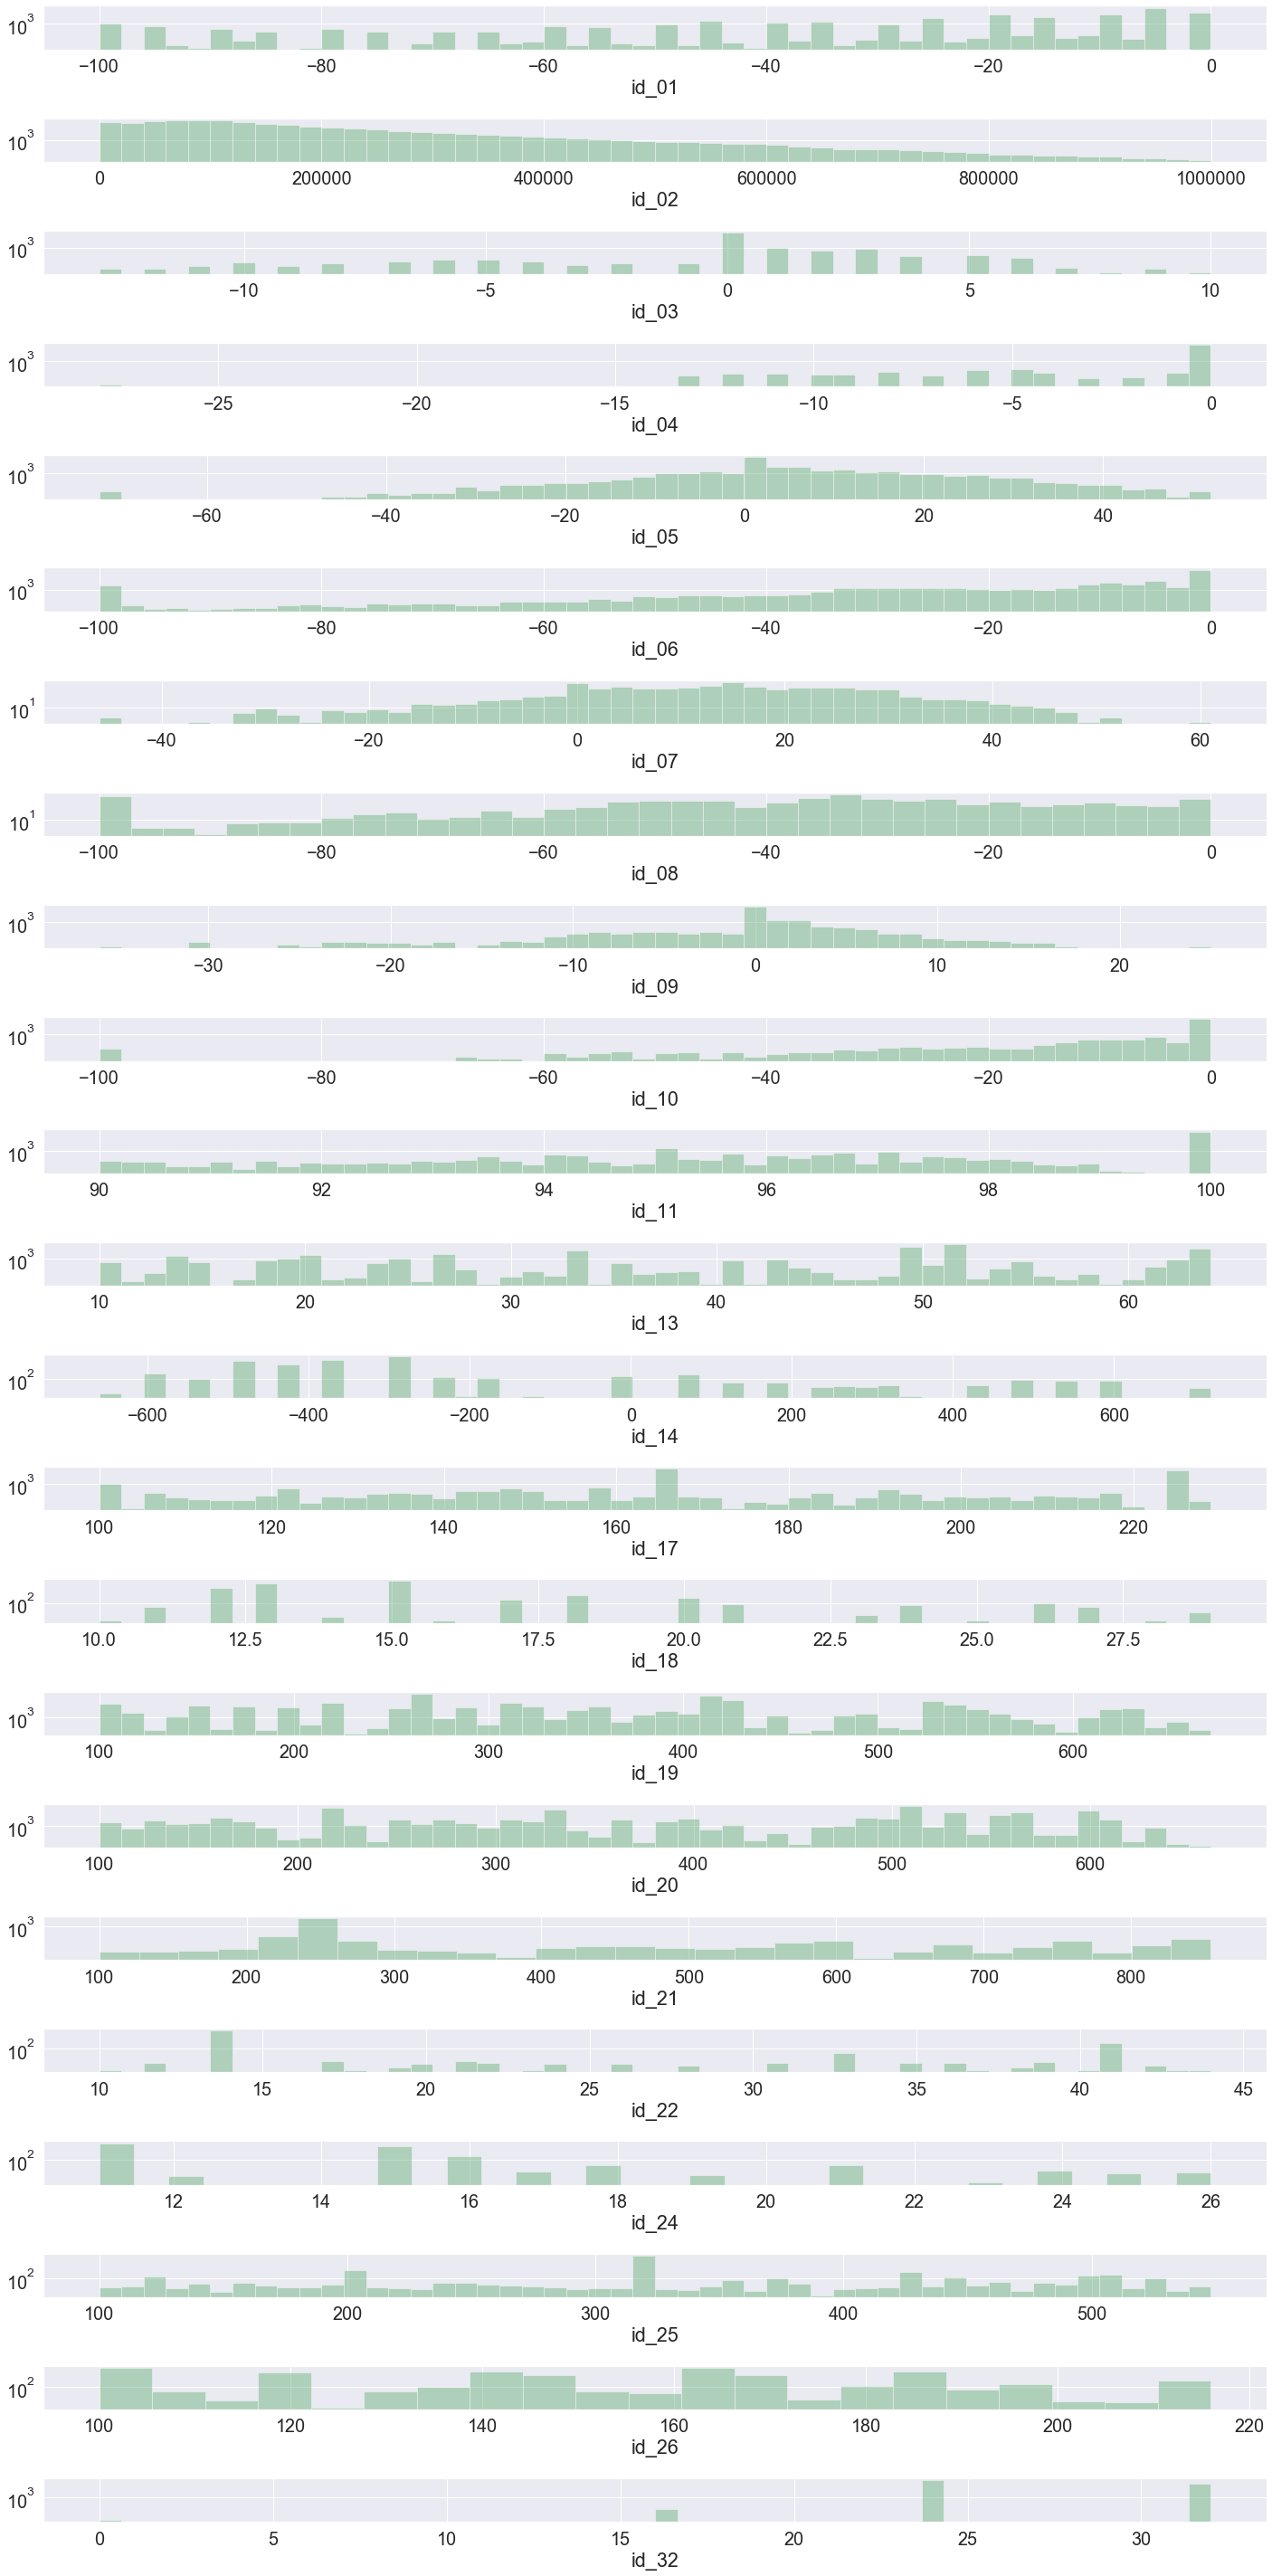

In [153]:
# Visualizing Continous Variables
ID = train.iloc[:,train.columns.get_loc('id_01'):train.columns.get_loc('id_38')+1]
ID_cont = ID.select_dtypes(exclude = 'object')

rows = ID_cont.shape[1]
f, axes = plt.subplots(rows, 1, figsize = (20, 40))
for i in range(rows):
    sns.distplot(ID_cont[ID_cont.columns[i]].dropna(), kde = False, hist_kws = {'log':True}, ax = axes[i], color = 'g')
plt.tight_layout()

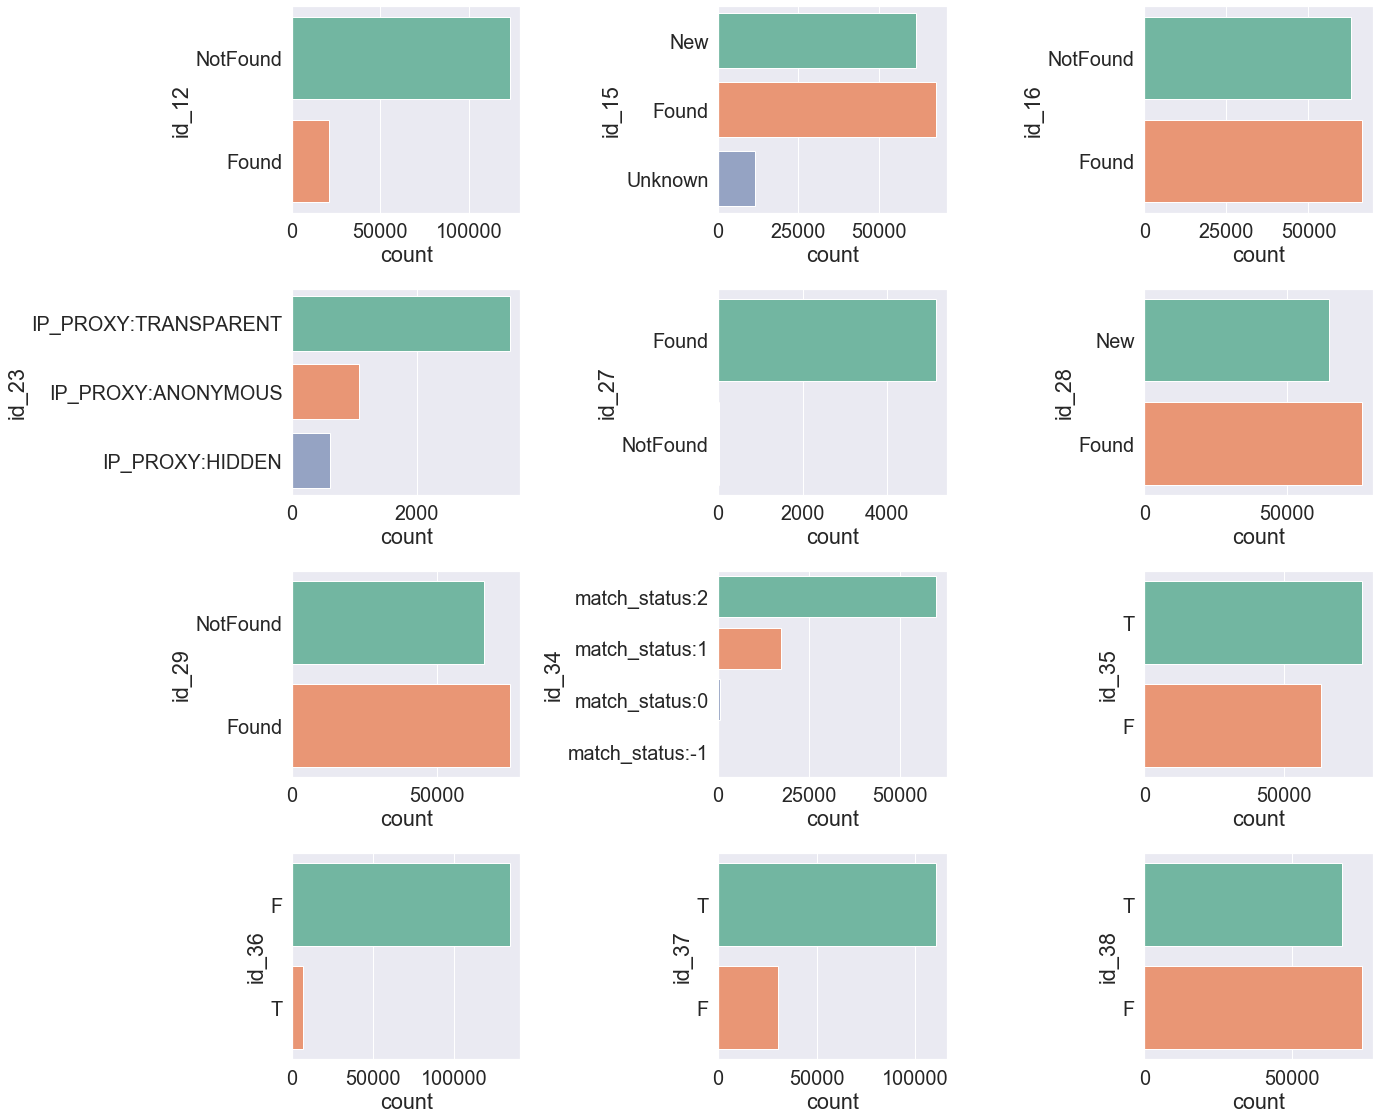

In [154]:
# Visualizing Categorical Variables
ID_cat = ID.select_dtypes(include = 'object')
ID_cat_1 = ID_cat.drop(columns = ['id_30', 'id_31', 'id_33'])

f, axes = plt.subplots(4, 3, figsize = (20, 16))
count = 0
for i in range(4):
    for j in range(3):
        sns.countplot(y = ID_cat_1.columns[count], data = ID_cat_1, ax = axes[i, j], palette = 'Set2')
        count += 1
plt.tight_layout()

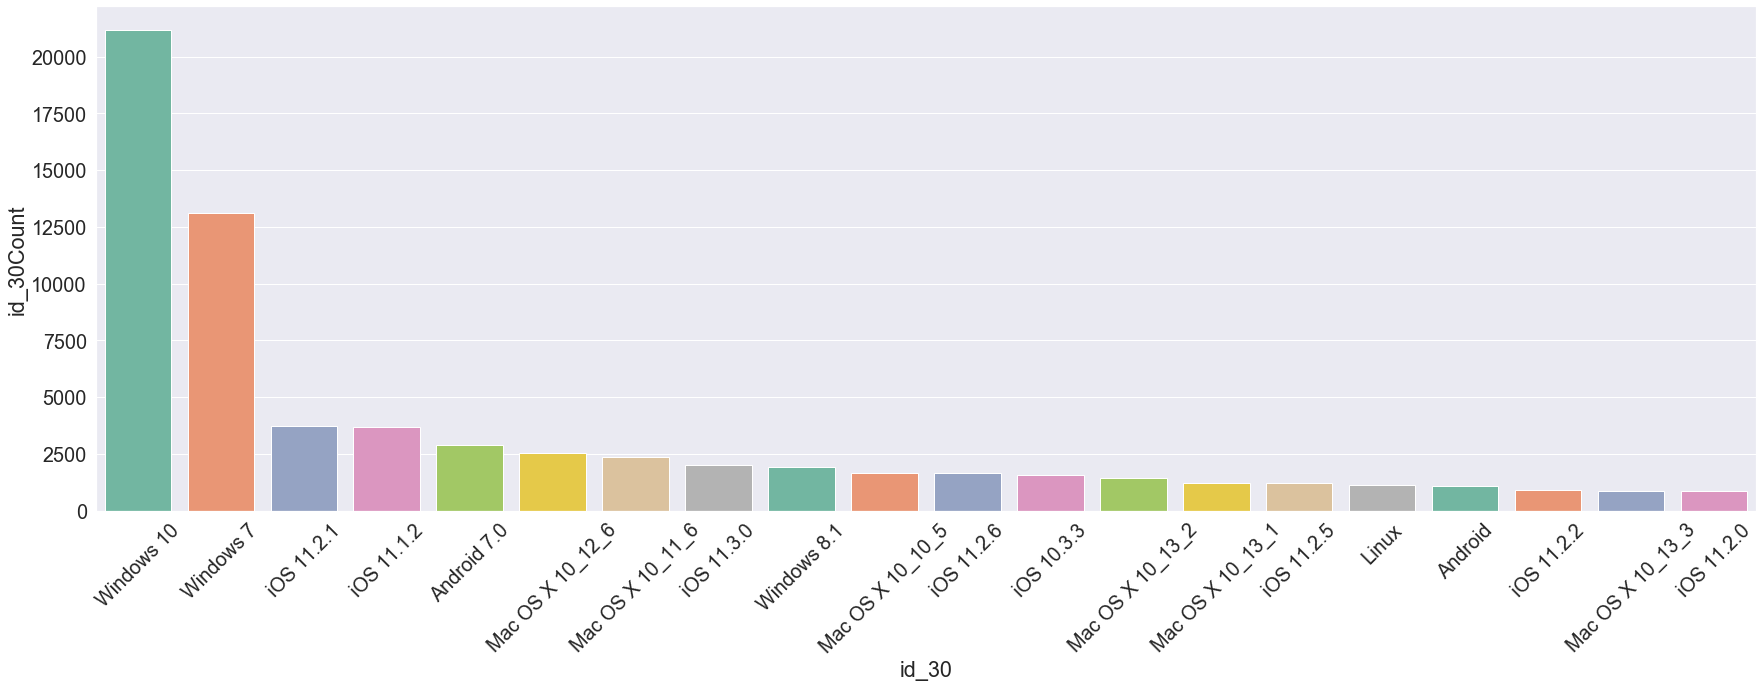

In [155]:
# Visualizing Categorical Variables
group = pd.DataFrame()
group['id_30Count'] = ID.groupby(['id_30'])['id_30'].count()
group['id_30'] = group.index
group_top = group.sort_values(by = 'id_30Count', ascending = False).head(20)

plt.figure(figsize = (25, 10))
sns.set(font_scale = 1.8)
sns.barplot(x = 'id_30', y = 'id_30Count', data = group_top, palette = 'Set2')
plt.xticks(rotation = 45)
plt.tight_layout()

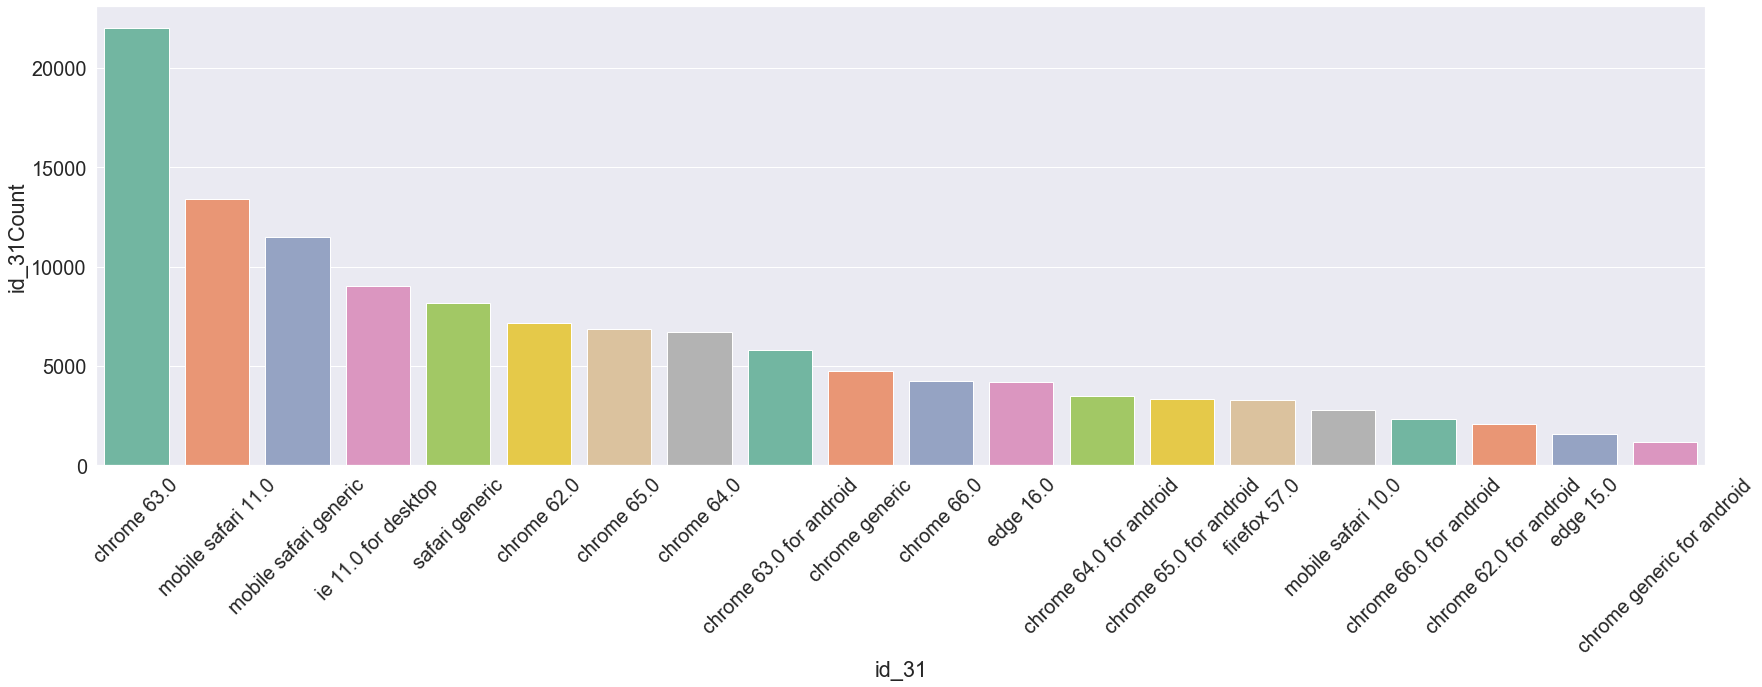

In [156]:
# Visualizing Categorical Variables
group = pd.DataFrame()
group['id_31Count'] = ID.groupby(['id_31'])['id_31'].count()
group['id_31'] = group.index
group_top = group.sort_values(by = 'id_31Count', ascending = False).head(20)

plt.figure(figsize = (25, 10))
sns.set(font_scale = 1.8)
sns.barplot(x = 'id_31', y = 'id_31Count', data = group_top, palette = 'Set2')
plt.xticks(rotation = 45)
plt.tight_layout()

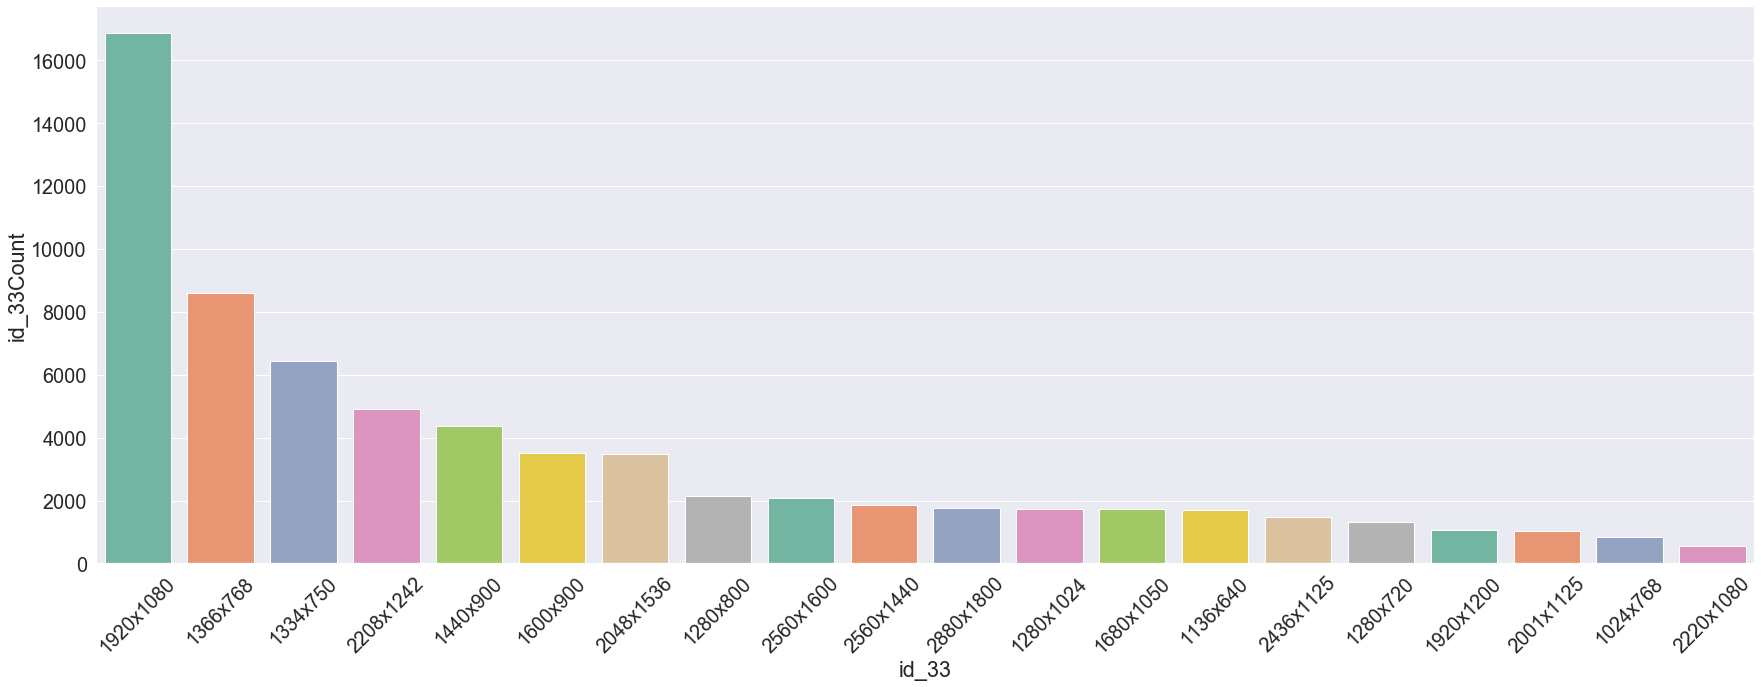

In [157]:
# Visualizing Categorical Variables
group = pd.DataFrame()
group['id_33Count'] = ID.groupby(['id_33'])['id_33'].count()
group['id_33'] = group.index
group_top = group.sort_values(by = 'id_33Count', ascending = False).head(20)

plt.figure(figsize = (25, 10))
sns.set(font_scale = 1.8)
sns.barplot(x = 'id_33', y = 'id_33Count', data = group_top, palette = 'Set2')
plt.xticks(rotation = 45)
plt.tight_layout()

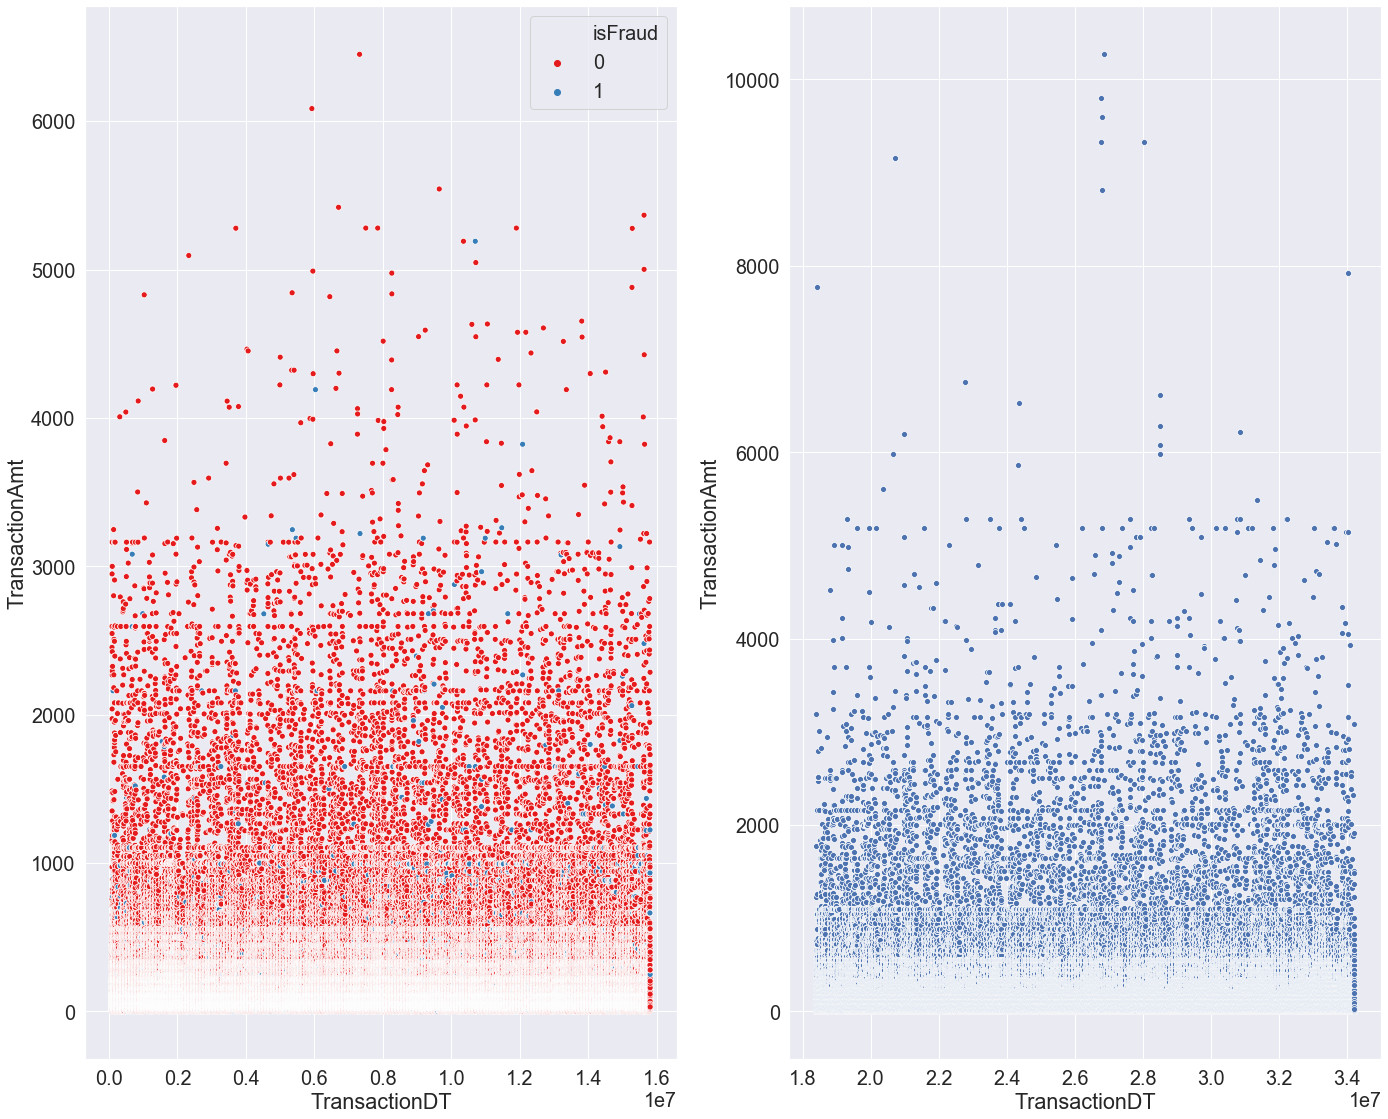

In [158]:
# Visualizing Transaction Amount Variables
f, axes = plt.subplots(1, 2, figsize = (20, 16))

train = train[train['TransactionAmt']<10000] # first graph had outliers so I removed those.

sns.scatterplot(x = train['TransactionDT'], y = train['TransactionAmt'], hue = train['isFraud'], ax = axes[0], palette = 'Set1')
sns.scatterplot(x = test['TransactionDT'], y = test['TransactionAmt'], ax = axes[1], palette = 'Set1')
plt.tight_layout()

## Feature Engineering

In [159]:
# Combining/Aggregating - simple aggregations on top features
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [160]:
# Feature Split
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand = True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand = True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand = True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand = True)

In [161]:
# Outliers
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna = False, normalize = True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna = False, normalize = True).values[0] > 0.9]

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [162]:
# Drop the selected columns
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

84

In [164]:
# Label Encoding
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 
            'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 
            'M8', 'M9', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 
            'R_emaildomain_3']

for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [168]:
# Prepare data for training and validation
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis = 1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.drop(['TransactionDT', 'TransactionID'], axis = 1)
test = test[["TransactionDT", 'TransactionID']]

In [169]:
# Remove inf values for the model
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan) 

X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

In [170]:
# initializing parameters for the light gradiant boosting
# I used the parameters from here - https://www.kaggle.com/artgor/eda-and-models
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [171]:
# Training the data
folds = TimeSeriesSplit(n_splits = 5)

aucs = list() # creates a list AUC scores
feature_importances = pd.DataFrame() # a data frame for the top features
feature_importances['feature'] = X.columns

evals_result = {}

training_start_time = time()

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    train_data = lgb.Dataset(X.iloc[train_id], label = y.iloc[train_id])
    val_data = lgb.Dataset(X.iloc[test_id], label = y.iloc[test_id])
    clf = lgb.train(params, train_data, 10000, valid_sets = [train_data, val_data], 
                    evals_result = evals_result, verbose_eval = 1000, early_stopping_rounds = 500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.999997	valid_1's auc: 0.901271
Early stopping, best iteration is:
[1464]	training's auc: 1	valid_1's auc: 0.901718
Fold 1 finished in 0:02:23.904714
Training on fold 2
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.99995	valid_1's auc: 0.920378
Early stopping, best iteration is:
[934]	training's auc: 0.99991	valid_1's auc: 0.920636
Fold 2 finished in 0:03:48.754140
Training on fold 3
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.999418	valid_1's auc: 0.911114
Early stopping, best iteration is:
[874]	training's auc: 0.998797	valid_1's auc: 0.911216
Fold 3 finished in 0:05:16.312283
Training on fold 4
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.997652	valid_1's auc: 0.933295
Early stopping, best iteration is:
[1218]	training's auc: 0.999011	valid_1's auc: 0.9336

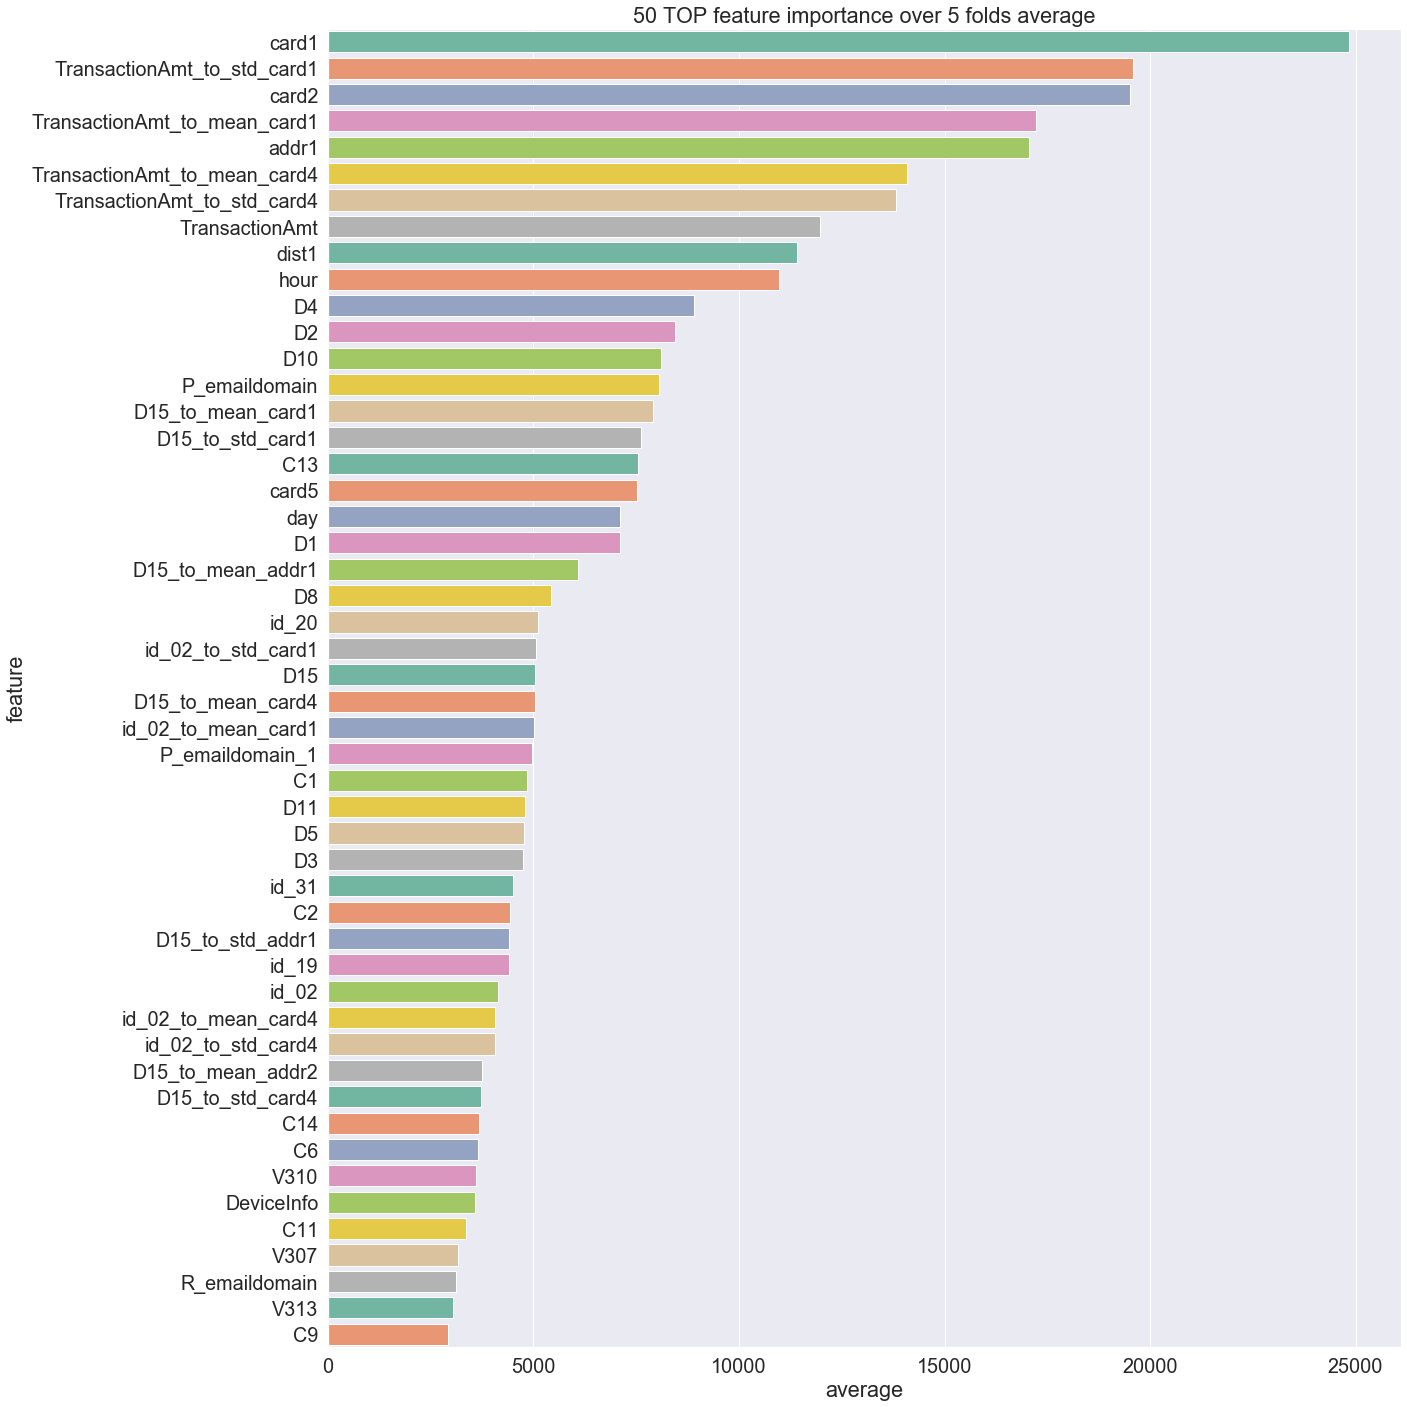

In [172]:
# selection of top features by light gbm model
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis = 1)

plt.figure(figsize = (20, 20))
sns.barplot(x = 'average', y = 'feature', data = feature_importances.sort_values(by = 'average', ascending = False).head(50), palette = 'Set2')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))
plt.tight_layout()